ONET Occupations Dataset
---

By Paul Duckworth 20th Sept 2017.

Create a Task Similarity Matrix from ONET datasets of Tasks, DWAs, IWAs and WAs. 

Use Future of Work survey as Ground Truth in 1D Gaussian Process to infer over all (DWA) Tasks. 


In [2]:
import os
import numpy as np
import pandas as pd
import pandas_ml as pdml
import getpass
import matplotlib.pyplot as plt
from random import shuffle
%matplotlib inline

datasets = '/home/'+ getpass.getuser() +'/Datasets/'
print datasets


/home/scpd/Datasets/


## ONET TASK data:


In [3]:
tasks = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/Task Statements.txt'), sep='\t')
tasks = tasks[['Task ID', 'Task']]
#tasks = tasks.loc[range(20)]     # reduce the task matrix for now :)
tasks.shape

(19566, 2)

In [25]:
#Task DWAs (detailed work activitiy code):
taskDWA = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/Tasks to DWAs.txt'), sep='\t')
taskDWA = taskDWA[['Task ID', 'DWA ID']]

print taskDWA.shape, "UNIQUE DWA: ", len(taskDWA['DWA ID'].unique()) 
print taskDWA.head()

(22838, 2) UNIQUE DWA:  2070
   Task ID             DWA ID
0    20461  4.A.2.a.4.I09.D03
1    20461  4.A.4.b.6.I08.D04
2     8823  4.A.4.b.4.I09.D02
3     8824  4.A.4.a.2.I03.D14
4     8825  4.A.2.a.4.I07.D09


In [26]:
df = pd.merge(tasks, taskDWA,  how='left', left_on=['Task ID'], right_on = ['Task ID']).sort_values(by = 'Task ID')
df = df[df['DWA ID'].notnull()]
df['IWA ID'] = df['DWA ID'].str.slice(0,-4)    # create IWA ID
df['WA ID'] = df['DWA ID'].str.slice(0,-8)     # create WA ID

## ADD DWA and IWA titles:
DWAref = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/DWA Reference.txt'), sep='\t')[['DWA ID', 'DWA Title']]
df2 = pd.merge(df, DWAref,  how='left', left_on=['DWA ID'], right_on = ['DWA ID'])

IWAref = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/IWA Reference.txt'), sep='\t')[['IWA ID', 'IWA Title']]
df3 = pd.merge(df2, IWAref,  how='left', left_on=['IWA ID'], right_on = ['IWA ID'])

cols = ['Observed Occupation', 'O*NET Occupation title', 'O*NET-SOC Code','Description']
df3[['Task ID', 'Task', 'DWA ID', 'DWA Title', 'IWA ID', 'IWA Title', 'WA ID']]

print df3.shape
df3.head()

(22838, 7)


,Task ID,Task,DWA ID,IWA ID,WA ID,DWA Title,IWA Title
0,1,Resolve customer complaints regarding sales an...,4.A.4.a.8.I03.D05,4.A.4.a.8.I03,4.A.4.a.8,Resolve customer complaints or problems.,Respond to customer problems or inquiries.
1,2,Monitor customer preferences to determine focu...,4.A.1.a.1.I14.D04,4.A.1.a.1.I14,4.A.1.a.1,Conduct opinion surveys or needs assessments.,Collect data about consumer needs or opinions.
2,3,Direct and coordinate activities involving sal...,4.A.4.b.4.I12.D03,4.A.4.b.4.I12,4.A.4.b.4,"Direct sales, marketing, or customer service a...","Direct organizational operations, activities, ..."
3,4,Determine price schedules and discount rates.,4.A.2.b.4.I01.D06,4.A.2.b.4.I01,4.A.2.b.4,Determine pricing or monetary policies.,"Develop organizational policies, systems, or p..."
4,5,Review operational records and reports to proj...,4.A.2.a.4.I11.D06,4.A.2.a.4.I11,4.A.2.a.4,Analyze financial records or reports to determ...,Analyze business or financial data.


In [27]:
# Every IWA is linked to exactly one WA from the O*NET Content Model. 
# IWAs are linked to one or more DWAs; 

WA = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/Work Activities.txt'), sep='\t')
WA.rename(columns = {'Element ID':'WA ID', 'Element Name':'WA Title'}, inplace = True)
# WA[['WA IM Value', 'WA IM SE']] = WA[['Data Value', 'Standard Error']]  # This is per Occupation. 

WA = WA[WA['Scale ID'] == "IM"][['WA ID', 'WA Title']] #, 'WA IM Value', 'WA IM SE']]
WA.drop_duplicates(inplace=True)
print WA.shape
WA.head()

(41, 2)


,WA ID,WA Title
0,4.A.1.a.1,Getting Information
2,4.A.1.a.2,"Monitor Processes, Materials, or Surroundings"
4,4.A.1.b.1,"Identifying Objects, Actions, and Events"
6,4.A.1.b.2,"Inspecting Equipment, Structures, or Material"
8,4.A.1.b.3,Estimating the Quantifiable Characteristics of...


# Task Level Dataset

In [28]:
df4 = pd.merge(df3, WA, how='left', left_on=['WA ID'], right_on = ['WA ID']).sort_values(by = 'Task ID')
# df4[df4['Task ID'].notnull()]
print df4.shape

#df4[df4['IWA ID'].str.contains('4.A.4.b.4')].drop_duplicates(subset=['IWA ID'])#.sort_values(by = 'IWA ID')
df4.head()

(22838, 8)


,Task ID,Task,DWA ID,IWA ID,WA ID,DWA Title,IWA Title,WA Title
0,1,Resolve customer complaints regarding sales an...,4.A.4.a.8.I03.D05,4.A.4.a.8.I03,4.A.4.a.8,Resolve customer complaints or problems.,Respond to customer problems or inquiries.,Performing for or Working Directly with the Pu...
1,2,Monitor customer preferences to determine focu...,4.A.1.a.1.I14.D04,4.A.1.a.1.I14,4.A.1.a.1,Conduct opinion surveys or needs assessments.,Collect data about consumer needs or opinions.,Getting Information
2,3,Direct and coordinate activities involving sal...,4.A.4.b.4.I12.D03,4.A.4.b.4.I12,4.A.4.b.4,"Direct sales, marketing, or customer service a...","Direct organizational operations, activities, ...","Guiding, Directing, and Motivating Subordinates"
3,4,Determine price schedules and discount rates.,4.A.2.b.4.I01.D06,4.A.2.b.4.I01,4.A.2.b.4,Determine pricing or monetary policies.,"Develop organizational policies, systems, or p...",Developing Objectives and Strategies
4,5,Review operational records and reports to proj...,4.A.2.a.4.I11.D06,4.A.2.a.4.I11,4.A.2.a.4,Analyze financial records or reports to determ...,Analyze business or financial data.,Analyzing Data or Information


## obtain GTs from survey on Future of Employment

In [145]:
survey_data = pd.read_csv(os.path.join(datasets, 'FoEmployment/fow-expert-survey/data/cleaned/counts_data_with_metadata.csv'))
survey_data.rename(columns = {'title':'O*NET Occupation title', 
                              'Unnamed: 0': 'Task'}, inplace = True)

# Change Ordinal Data to Numeric - bit hacky
ratings = [4,3,2,1,0]
survey_data['GT Rating'] = (survey_data['Completely Automatable Today']*ratings[0] + survey_data['Could be Mostly Automated Today (Human Still Needed)']*ratings[1] + survey_data['Mostly Not Automatable Today (Human Does Most of It)']*ratings[2] + survey_data['Not Automatable Today']*ratings[3] + survey_data['Unsure']*ratings[4]) / survey_data['Number of Responses']                
                
survey_data = survey_data[['Task ID', 'GT Rating']]
print survey_data.count()
# survey_data.head()

Task ID      350
GT Rating    350
dtype: int64


In [146]:
# Do tasks overlap between occus? No probs not. merge this in... 
print survey_data.shape
print len(survey_data['Task ID'].unique())
# survey_data[survey_data.duplicated(subset='Task ID', keep=False) == True]


(350, 2)
348


In [147]:
task_dwa_rat = pd.merge(taskDWA, survey_data, how='left', left_on=['Task ID'], right_on = ['Task ID'])#.sort_values(by = 'Task ID')

print task_dwa_rat.shape
print "Instances of annotated DWA IDs: ", sum(task_dwa_rat['GT Rating'].notnull())   # boolean 
# task_dwa_rat[task_dwa_rat['GT Rating'].notnull()].head()

# task_dwa_rat[task_dwa_rat['GT Rating'].notnull()][task_dwa_rat['DWA ID'] == '4.A.4.b.4.I12.D39']

(22840, 3)
Instances of annotated DWA IDs:  416


In [148]:
DWA_mean_rating = task_dwa_rat.groupby(['DWA ID']).mean().reset_index().rename(columns = {'GT Rating':'DWA GT Rating'})
DWA_mean_rating.head() #[DWA_mean_rating['DWA ID'] == '4.A.4.b.4.I12.D39']

print "Unique DWAs Annotated = ", DWA_mean_rating[DWA_mean_rating['DWA GT Rating'].notnull()].shape

Unique DWAs Annotated =  (314, 3)


# DWA Level Dataset 

In [150]:
#consistency check: how many DWAs are mapped up from Task to DWA (all 2070 :)
print len(DWA_mean_rating['DWA ID'].unique())

keep_columns = ['DWA ID', 'DWA GT Rating', 'IWA ID', 'WA ID', 'DWA Title', 'IWA Title', 'WA Title']
df5 = pd.merge(df4, DWA_mean_rating, how='left', left_on=['DWA ID'], right_on = ['DWA ID'])[keep_columns].drop_duplicates(subset=keep_columns)
print df5.shape
# df5[df5['DWA GT Rating'].notnull()].head()



2070
(2070, 7)


# Split into Train, Validate and Test set

In [160]:
val_size = 0

data = df5.reset_index()
X = data[data['DWA GT Rating'].notnull()].reset_index()
test = df5[df5['DWA GT Rating'].isnull()].reset_index()
y = X['DWA GT Rating']

# Create a Validation set
msk = [i for i in range(X.shape[0])]
# shuffle(msk)
    
n_validation_set = int(np.floor(X.shape[0]*val_size))
print n_validation_set

train = X.iloc[msk[n_validation_set:]]
valid = X.iloc[msk[:n_validation_set]]

print train.shape
print valid.shape
print test.shape
print y.shape

# test = X[msk[:n_validation_set]]

0
(314, 9)
(0, 9)
(1756, 8)
(314,)


In [151]:
def similarity_kernel(A, B, args):
    K = np.zeros([A.shape[0], B.shape[0]])
    
    for index, row in A.iterrows(): 
        matchesIWA = row['IWA ID'] == B['IWA ID']
        matchesWA = row['WA ID'] == B['WA ID']
        update_cov_row = matchesIWA*args[0] + matchesWA*args[1]  # operators on bool vectors works fine
        K[index] += update_cov_row

#     K_ = (K - K.min(axis=0)) / (K.max(axis=0) - K.min(axis=0))
    return K
    
theta = (0.9, 0.6)  # current guess at similarity between DWA-IWA and DWA-WA

K = similarity_kernel(train, train, theta)
Ks = similarity_kernel(train, test, theta)
Kss = similarity_kernel(test, test, theta)


3659.4 (314, 314)


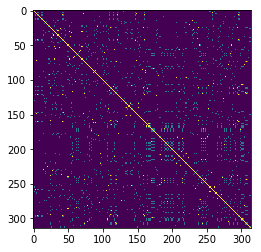

In [153]:
# Normalise the covariance matrices: 
# K = (K_ - K_.min(axis=0)) / (K_.max(axis=0) - K_.min(axis=0))
# Ks = (Ks_ - Ks_.min(axis=0)) / (Ks_.max(axis=0) - Ks_.min(axis=0))
# Kss = (Kss_ - Kss_.min(axis=0)) / (Kss_.max(axis=0) - Kss_.min(axis=0))

print K.sum(), K.shape
plt.imshow(K)

## Gaussian Process this:

In [152]:
def gaussian_process(K, Ks, y):
    N = K.shape[0]
    jitter = 1e-6

    # decompose K (instead of inversion)
    L = np.linalg.cholesky(K + jitter*np.eye(N))   # Notice the gaussian noise term added to K. (Ky)

    # # solve for m where: L*m = y
    m = np.linalg.solve(L, y)

    # # solve for alpha where: L.T*alpha = m
    alpha = np.linalg.solve(L.T, m)

    # compute the posterior mean for test points Ks
    mu = np.dot(Ks.T, alpha)


    # compute the variance at our test points
    # solve for v where: Lv = Kstar
    v = np.linalg.solve(L, Ks)  

    var = np.diag(Kss) - np.sum(v**2, axis=0)
    std = np.sqrt(var)

    LML = -0.5*np.dot(y.T, alpha) - sum(np.log(np.diag(L))) - 0.5*N*np.log(2*np.pi) # larger (negative) better
    return mu, std, LML

# mu, std, LML = gaussian_process(K, Ks, y)


# Mean Inferred Task Rating:

This is a mean GT Rating score for all the test DWA points based on their similarity to the training DWAs - defined by $\Theta$:


In [154]:
for cnt, (index, row), in enumerate(test.iterrows()):
    print "mean = %0.3f, std = %0.4f. DWA = %s" % (mu[cnt], std[cnt], row['DWA Title'])
    
print "\nThis seems OK: ", max(mu)

mean = 2.704, std = 0.0006. DWA = Resolve customer complaints or problems.
mean = 3.600, std = 0.0010. DWA = Conduct opinion surveys or needs assessments.
mean = 2.361, std = 0.0004. DWA = Direct sales, marketing, or customer service activities.
mean = 1.542, std = 0.0007. DWA = Determine pricing or monetary policies.
mean = 3.444, std = 0.0010. DWA = Analyze financial records or reports to determine state of operations.
mean = 2.429, std = 0.0004. DWA = Confer with organizational members to accomplish work activities.
mean = 2.800, std = 0.0010. DWA = Approve expenditures.
mean = 1.845, std = 0.9974. DWA = Represent the organization in external relations.
mean = 2.025, std = 0.9891. DWA = Manage human resources activities.
mean = 0.000, std = 1.2247. DWA = Establish interpersonal business relationships to facilitate work activities.
mean = 3.167, std = 0.0007. DWA = Advise customers on technical or procedural issues.
mean = 1.528, std = 1.0488. DWA = Evaluate potential of products, te

mean = 2.412, std = 0.0010. DWA = Report news to the public.
mean = 2.287, std = 0.9928. DWA = Gather information for news stories.
mean = 2.128, std = 0.0006. DWA = Interview others for news or entertainment purposes.
mean = 2.025, std = 0.9891. DWA = Host events.
mean = 3.117, std = 0.0006. DWA = Maintain logs of production activities.
mean = 2.034, std = 0.0006. DWA = Perform for recordings.
mean = 1.909, std = 1.0029. DWA = Analyze information obtained from news sources.
mean = 3.167, std = 0.0010. DWA = Research new technologies.
mean = 2.893, std = 0.0007. DWA = Notify others of equipment problems.
mean = 2.157, std = 1.0100. DWA = Mix sound inputs.
mean = 0.000, std = 1.2247. DWA = Maintain recording or broadcasting equipment.
mean = 2.552, std = 0.9687. DWA = Set up still or video cameras or related equipment.
mean = 3.069, std = 0.0007. DWA = Convert data among multiple digital or analog formats.
mean = 2.048, std = 1.0488. DWA = Operate audio recording equipment.
mean = 2.244

In [161]:
N = K.shape[0]
# LML = -0.5*np.dot(y.values.T, alpha) - sum(np.log(np.diag(L))) - 0.5*N*np.log(2*np.pi) # larger (negative) better
print LML

-17525640.7446


# Optimisation

In [164]:
def f_to_optimise(train, valid, test, y, args):
    sigma = args[-1]
    theta = (args[0], args[1])
    K = similarity_kernel(train, train, theta) + sigma*np.eye(X.shape[0])
    Ks = similarity_kernel(train, test, theta)
    #Kss = similarity_kernel(Xtest, Xtest, theta)
    
    mu, std, LML = gaussian_process(K, Ks, y)
    return LML


In [165]:
# Grid search the likelihood space: 
theta1 = np.linspace(0.1, 1, 10)
theta2 = np.linspace(0, 1, 10)
LMLs = np.zeros((len(theta1), len(theta2)))

for t1 in  xrange(len(theta1)):
    for t2 in  xrange(len(theta2)):
        #if t2 > t1: continue
        args = (theta1[t1], theta2[t2], 1e-1)
        print "theta = (%0.3f, %0.3f)" %(args[0], args[1])
        
        LMLs[t1, t2] = f_to_optimise(train, valid, test, y.values, args)
       

theta = (0.100, 0.000)
theta = (0.100, 0.111)
theta = (0.100, 0.222)
theta = (0.100, 0.333)
theta = (0.100, 0.444)
theta = (0.100, 0.556)
theta = (0.100, 0.667)
theta = (0.100, 0.778)
theta = (0.100, 0.889)
theta = (0.100, 1.000)
theta = (0.200, 0.000)
theta = (0.200, 0.111)
theta = (0.200, 0.222)
theta = (0.200, 0.333)
theta = (0.200, 0.444)
theta = (0.200, 0.556)
theta = (0.200, 0.667)
theta = (0.200, 0.778)
theta = (0.200, 0.889)
theta = (0.200, 1.000)
theta = (0.300, 0.000)
theta = (0.300, 0.111)
theta = (0.300, 0.222)
theta = (0.300, 0.333)
theta = (0.300, 0.444)
theta = (0.300, 0.556)
theta = (0.300, 0.667)
theta = (0.300, 0.778)
theta = (0.300, 0.889)
theta = (0.300, 1.000)
theta = (0.400, 0.000)
theta = (0.400, 0.111)
theta = (0.400, 0.222)
theta = (0.400, 0.333)
theta = (0.400, 0.444)
theta = (0.400, 0.556)
theta = (0.400, 0.667)
theta = (0.400, 0.778)
theta = (0.400, 0.889)
theta = (0.400, 1.000)
theta = (0.500, 0.000)
theta = (0.500, 0.111)
theta = (0.500, 0.222)
theta = (0.

/home/scpd/Software/anaconda3/envs/gpflow_env/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt


theta = (0.700, 0.000)
theta = (0.700, 0.111)
theta = (0.700, 0.222)
theta = (0.700, 0.333)
theta = (0.700, 0.444)
theta = (0.700, 0.556)
theta = (0.700, 0.667)
theta = (0.700, 0.778)
theta = (0.700, 0.889)
theta = (0.700, 1.000)
theta = (0.800, 0.000)
theta = (0.800, 0.111)
theta = (0.800, 0.222)
theta = (0.800, 0.333)
theta = (0.800, 0.444)
theta = (0.800, 0.556)
theta = (0.800, 0.667)
theta = (0.800, 0.778)
theta = (0.800, 0.889)
theta = (0.800, 1.000)
theta = (0.900, 0.000)
theta = (0.900, 0.111)
theta = (0.900, 0.222)
theta = (0.900, 0.333)
theta = (0.900, 0.444)
theta = (0.900, 0.556)
theta = (0.900, 0.667)
theta = (0.900, 0.778)
theta = (0.900, 0.889)
theta = (0.900, 1.000)
theta = (1.000, 0.000)
theta = (1.000, 0.111)
theta = (1.000, 0.222)
theta = (1.000, 0.333)
theta = (1.000, 0.444)
theta = (1.000, 0.556)
theta = (1.000, 0.667)
theta = (1.000, 0.778)
theta = (1.000, 0.889)
theta = (1.000, 1.000)


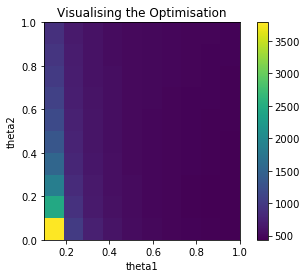

In [167]:
plt.imshow(-LMLs, extent=[min(theta1),max(theta1),min(theta2),max(theta2)], aspect=1, origin='lower')
plt.colorbar()
plt.xlabel("theta1"), plt.ylabel("theta2"), plt.title("Visualising the Optimisation")
plt.show()

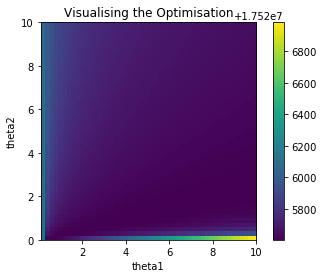

In [1284]:
# with a much bigger scale of theta - it gets interesting around theta1 = 10? 
plt.imshow(-LMLs, extent=[min(theta1),max(theta1),min(theta2),max(theta2)], aspect=1, origin='lower')
plt.colorbar()
plt.xlabel("theta1"), plt.ylabel("theta2"), plt.title("Visualising the Optimisation")
plt.show()

# Sanity Checks: 

In [166]:
# Top 10 most and Least Automatable Inferred Task Ratings: 
appended_list = []
for cnt, (index, row), in enumerate(test.iterrows()):
    if row['WA ID'] in ['4.A.4.a.4','4.A.3.b.4']:   # These two WA's don't have any training data
        continue
    appended_list.append((mu[cnt], std[cnt], row['DWA Title'], row['WA ID']))

# for i in [(y[0], y[3], y[2]) for y in sorted(appended_list, key=lambda x: x[0])[:10]]:
#     print i

# print "\n"
# for i in [(y[0], y[3], y[2]) for y in sorted(appended_list, key=lambda x: x[0])[-10:]]:
#     print i  

In [1249]:
# 2 WA's are not represented in the training data - so they come out with 0 Automatability. 
print '4.A.3.b.4' in  X['WA ID'].unique()
print '4.A.4.a.4' in  X['WA ID'].unique()

print len(X['WA ID'].unique())
print len(Xtest['WA ID'].unique())
print len(df5['WA ID'].unique())

False
False
35
37
37


In [1250]:
print "Training Set: "
print "number of DWAs per IWA in training data = %0.3f" % X.groupby(['IWA ID']).count()['DWA ID'].mean()
# print "number of IWAs per WA in training data = %0.3f" % X.drop_duplicates(subset=['WA ID', 'IWA ID']).groupby(['WA ID']).count()['IWA ID'].mean()
# print "number of DWAs per WA in training data = %0.3f" % X.drop_duplicates(subset=['WA ID', 'IWA ID', 'DWA ID']).groupby(['WA ID']).count()['DWA ID'].mean()

# add negative penalties for sharing IWA 

print "\nTest Set: "
print "number of DWAs per IWA in test data = %0.3f" % Xtest.groupby(['IWA ID']).count()['DWA ID'].mean()
# print "number of IWAs per WA in test data = %0.3f" % Xtest.drop_duplicates(subset=['WA ID', 'IWA ID']).groupby(['WA ID']).count()['IWA ID'].mean()
# print "number of DWAs per WA in test data = %0.3f" % Xtest.drop_duplicates(subset=['WA ID', 'IWA ID', 'DWA ID']).groupby(['WA ID']).count()['DWA ID'].mean()

# print "\n"
# print X.groupby(['IWA ID']).count()['DWA ID']
# print Xtest.groupby(['IWA ID']).count()['DWA ID']



Training Set: 
number of DWAs per IWA in training data = 1.847

Test Set: 
number of DWAs per IWA in test data = 5.370
